# Fraudulent User Detection Using Amazon Dataset
### Penghao Xu, Yuan Chen, Jiawei Wu, Haojing Lu

## Part 3. Proposed New Methods

This script is used to apply our proposed new model to fraudulent user detection on Amazon review dataset.


In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import time

torch.manual_seed(3407)

In [3]:
dataset_path = "dataset"

# inputs
files = {}
files['train'] = f'{dataset_path}/toy_embedded_review_train.csv'
files['val'] = f'{dataset_path}/toy_embedded_review_val.csv'
files['test'] = f'{dataset_path}/toy_embedded_review_test.csv'
# files['all'] = f'{dataset_path}/all_embedded_review.csv'

# labels
label_files = {}
label_files['train'] = f'{dataset_path}/toy_label_train.csv'
label_files['val'] = f'{dataset_path}/toy_label_val.csv'
label_files['test'] = f'{dataset_path}/toy_label_test.csv'
# label_files['all'] = f'{dataset_path}/user_label_all.csv'

In [4]:
# check cuda availablity
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

In [5]:
datafile = files['train']

with open(datafile, 'r') as fr:
    data={}
    ws = next(fr).rstrip('\n').split(',')
    print(ws)
    ws = next(fr).rstrip('\n').split(',')
    print(ws)

['reviewerID', 'asin', 'rating', '0', '1', '2', '3', '4', '5', '6', '7']
['A14CC5FIPR5YVF', '0001055178', '0.5', '0.2596393909493942', '0.17837421036491835', '0.25450734021697347', '0.0816767029552047', '0.4163100006029723', '0.6862006368173601', '0.08002756848170138', '0.42277087816745107']


### Load data
Here, we load all scores and embeddings and group them in each user

In [6]:
# load data and group by products
def load_data(datafile):
    with open(datafile, 'r') as fr:
        data = {}
        fr.readline()
        for l in fr:
            ws = l.rstrip('\n').split(',')
            emb_dim = len(ws) - 2
            if ws[1] not in data:
                data[ws[1]] = []
            data[ws[1]].append([ws[0], ws[1], torch.tensor([float(x) for x in ws[2:]])])
    return data, emb_dim

# load labels and sort in users order
def load_labels(labelfile, device):
    with open(labelfile, 'r') as fr:
        fr.readline()
        user_labels = []
        for l in fr:
            ws = l.rstrip('\n').split(',')
            user_labels.append((ws[0], float(ws[1]))) 
        user_labels.sort()
        user_labels = torch.tensor([float((x[1] > 0.5)) for x in user_labels]).to(device) # label 1 if helffulness > 0.5, label 0 if helpfulness < 0.5
        # user_labels = torch.tensor([(x[1]) for x in user_labels]).to(device)
    return user_labels

In [7]:
# load all, train, val, and test files
data = {}
labels = {}
for t in ['train', 'val', 'test', 'all']:
    if t in files and t in label_files:
        data[t], emb_dim = load_data(files[t])
        labels[t] = load_labels(label_files[t], device)
        print(f'Statistics for {t} dataset:')
        print(f'Total users: {len(labels[t])}')
        print(f'Total products: {len(data[t])}')

Statistics for train dataset:
Total users: 12734
Total products: 18525
Statistics for val dataset:
Total users: 13571
Total products: 20823
Statistics for test dataset:
Total users: 12770
Total products: 18426


In [8]:
labels['train'] 

tensor([1., 0., 1.,  ..., 0., 0., 0.], device='cuda:0')

### Build model
This model takes the text embeddings and scores to predict the user helpfulness and detect fraudulent users using the following formula:

$$
\overrightarrow{G(p)} = AGG(RNN(\overrightarrow{S(u, p)}, \forall u \in U),  \Pi_p)
$$
$$
\overrightarrow{R(u, p)} = NN(\overrightarrow{S(u, p)}, \overrightarrow{G(p)})
$$
$$
F(u) = AGG(\overrightarrow{R(u, p)}, \forall p \in P, \overrightarrow{\Pi_u}) 
$$

In this very first model, the product and user embeddings are removed. We used the following formula:
$$
\overrightarrow{G(p)} = GRU(\overrightarrow{S(u, p)}, \forall u \in U)
$$
$$
\overrightarrow{R(u, p)} = NN(\overrightarrow{S(u, p)}, \overrightarrow{G(p)})
$$
$$
F(u) = GRU(\overrightarrow{R(u, p)}, \forall p \in P) 
$$

In [9]:
# helper function to convert text embeddings of a product
def emb2tensor(data, dim):
    """
    input: 
        data: list, review information list. data[i][0]-reviewerID, data[i][1]-asin, data[i][2]-rating&text-embedding

    """
    product = data[0][1]
    tensor = torch.zeros((len(data), 1, dim))
    for i, d in enumerate(data):
        tensor[i,:,:] = d[-1]
    return tensor, product
emb2tensor(data['train'][list(data['train'].keys())[0]], emb_dim)

(tensor([[[0.5000, 0.2596, 0.1784, 0.2545, 0.0817, 0.4163, 0.6862, 0.0800,
           0.4228]],
 
         [[1.0000, 0.6770, 0.4070, 0.0000, 0.0000, 0.3799, 0.3296, 0.0000,
           0.3508]],
 
         [[0.5000, 0.3462, 0.1784, 0.2545, 0.0544, 0.4996, 0.6982, 0.1067,
           0.1794]]]),
 '0001055178')

In [10]:
class FUD_FC(nn.Module):
    def __init__(self, emb_dim, device):
        super().__init__()
        # get parameters
        self.dim = emb_dim
        # set layers
        self.fc = nn.Linear(emb_dim, 32)
        self.fc1 = nn.Linear(emb_dim + 32, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)
        self.device = device
    
    def forward(self, x):
        # calculate gp
        gp = {}
        for su in x.values(): # iterate over products' reviews, su for all reviews received by a certain product
            tensor, p = emb2tensor(su, self.dim) # tensor'dim = (reviews_num, 1, emb_dim)
            gp[p] = F.relu(self.fc(tensor.to(self.device).mean(dim=0))).view(-1)
        # calculate rup
        rup = {}
        for su in x.values(): # iterate over products' reviews, su for all reviews received by a certain product
            for r in su:
                u, p, s = r # ReviewerID, Product, Feature Tensor
                s = torch.cat((s.to(device), gp[p]))
                if u not in rup:
                    rup[u] = [] # store all reviews given by "u"
                rup[u].append(F.relu(self.fc2(F.relu(self.fc1(s)))))
        # fairness for users
        fu = []
        for u in sorted(rup.keys()):
            v = torch.stack(rup[u], dim=1).view(len(rup[u]), 1, 16)
            fu.append(F.sigmoid(self.fc3(v.mean(dim=0))))
        return torch.cat(fu)

In [11]:
class FUD_GRU(nn.Module):
    def __init__(self, emb_dim, device):
        super().__init__()
        # get parameters
        self.dim = emb_dim
        # set layers
        self.GRU = nn.GRU(emb_dim, 32)
        self.fc1 = nn.Linear(emb_dim + 32, 16)
        self.fc2 = nn.Linear(16, 16)
        self.GRU2 = nn.GRU(16, 1)
        self.sigmoid = nn.Sigmoid()
        self.device = device
    
    def forward(self, x):
        # calculate gp
        gp = {}
        for su in x.values():
            tensor, p = emb2tensor(su, self.dim)
            gp[p] = self.GRU(tensor.to(self.device))[-1].view(-1)
        # calculate rup
        rup = {}
        for su in x.values():
            for r in su:
                u, p, s = r
                s = torch.cat((s.to(device), gp[p]))
                if u not in rup:
                    rup[u] = []
                rup[u].append(self.fc2(F.relu(self.fc1(s))))
        # fairness for users
        fu = []
        for u in sorted(rup.keys()):
            v = torch.stack(rup[u], dim=1).view(len(rup[u]), 1, 16)
            fu.append(self.sigmoid(self.GRU2(v)[-1]))
        return torch.cat(fu)

### Train model

In [12]:
model = FUD_FC(emb_dim, device).to(device)
model

FUD_FC(
  (fc): Linear(in_features=9, out_features=32, bias=True)
  (fc1): Linear(in_features=41, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [13]:
# Set up loss function
criterion = nn.BCELoss()
train_losses = []
val_losses = []
epoch_time = []

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-7)
epochs = 30
report_epoch = 1

for i in range(epochs):
    start_time = time.time()
    model.train()
    y_pred = model(data['train'])
    loss = criterion(y_pred.view(-1), labels['train'])
    print('loss calculated')
    optimizer.zero_grad()
    loss.backward()
    if i > 10:
        optimizer.param_groups[0]['lr'] = 1e-3
    if i > 20: 
        optimizer.param_groups[0]['lr'] = 1e-4
    optimizer.step()
    train_losses.append(loss.view(-1).cpu().detach().numpy()[0])
    if not i % report_epoch:
        model.eval()
        pred = model(data['val'])
        val_loss = criterion(pred.view(-1), labels['val'])
        val_losses.append(val_loss.view(-1).cpu().detach().numpy()[0])
        cost_time = time.time() - start_time
        epoch_time.append(cost_time)
        print(f'Epoch {i}, Train Loss: {train_losses[-1]:.6f}, Val. Loss: {val_losses[-1]:.6f}, cost {time.time() - start_time}s')

C:\Users\wjw18\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss calculated
Epoch 0, Train Loss: 0.642778, Val. Loss: 0.616682, cost 93.59408760070801s
loss calculated
Epoch 1, Train Loss: 0.614561, Val. Loss: 0.586297, cost 95.39678573608398s
loss calculated
Epoch 2, Train Loss: 0.583236, Val. Loss: 0.550620, cost 101.41609692573547s
loss calculated
Epoch 3, Train Loss: 0.547217, Val. Loss: 0.508068, cost 98.55379438400269s
loss calculated
Epoch 4, Train Loss: 0.504450, Val. Loss: 0.458139, cost 97.9505443572998s
loss calculated
Epoch 5, Train Loss: 0.454604, Val. Loss: 0.402362, cost 99.35504364967346s
loss calculated
Epoch 6, Train Loss: 0.399145, Val. Loss: 0.344483, cost 100.03552103042603s
loss calculated
Epoch 7, Train Loss: 0.341963, Val. Loss: 0.291297, cost 100.5773675441742s
loss calculated
Epoch 8, Train Loss: 0.289455, Val. Loss: 0.251617, cost 97.44920754432678s
loss calculated
Epoch 9, Train Loss: 0.250221, Val. Loss: 0.233190, cost 98.29795241355896s
loss calculated
Epoch 10, Train Loss: 0.231912, Val. Loss: 0.237269, cost 98.20

Save model weights if needed

In [ ]:

torch.save(model.state_dict(), 'Model_weights_gru.tar')

Visualize training process

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.set(style='ticks', font_scale=1.5)
plt.plot(list(range(epochs)), train_losses, color='b', label='Train loss')
plt.plot(list(range(0, epochs, report_epoch)), val_losses, color='r', label='Val. loss')
plt.ylabel('BCE Loss')
plt.xlabel('Epochs')
plt.title('Training process')
plt.legend()
sns.despine()

### Evaluate model
Evaluate model on train, val, test, and all dataset

In [ ]:
# Making Prediction
preds = {}
preds['val'] = model(data['val']).view(-1).cpu().detach().numpy()
preds['test'] = model(data['test']).view(-1).cpu().detach().numpy()
preds_prob = preds.copy()

th = 0.5
preds['val'] = preds['val'] >= th
preds['test'] = preds['test'] >= th

In [ ]:
th = 0.5
preds['val'] = preds['val'] >= th
preds['test'] = preds['test'] >= th

In [ ]:
# Evaluate
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

y_true = {}

labels['val'].to

metrics = {}
for k in ['val', 'test']:
    metrics[k] = {}
    y_true[k] = labels[k].clone().view(-1).cpu().detach().numpy()
    metrics[k]['accuracy_score'] = accuracy_score(y_pred=preds[k], y_true=y_true[k])
    metrics[k]['f1_score'] = f1_score(y_pred=preds[k], y_true=y_true[k])
    metrics[k]['precision'] = precision_score(y_pred=preds[k], y_true=y_true[k])
    metrics[k]['recall'] = recall_score(y_pred=preds[k], y_true=y_true[k])
    metrics[k]['roc_auc_score'] = roc_auc_score(y_score=preds_prob[k], y_true=y_true[k])
metrics


{'val': {'accuracy_score': 0.9339031758897649,
  'f1_score': 0.965822061345018,
  'precision': 0.9339031758897649,
  'recall': 1.0,
  'roc_auc_score': 0.5659754896346756},
 'test': {'accuracy_score': 0.9347689898198903,
  'f1_score': 0.9662848585421135,
  'precision': 0.9347689898198903,
  'recall': 1.0,
  'roc_auc_score': 0.5416270554464561}}

In [ ]:
np.histogram(preds_prob['test'])

(array([ 258, 4273, 4688,  130,  231,  498,  556,  571,  514, 1051],
       dtype=int64),
 array([0.61763585, 0.65587217, 0.6941084 , 0.73234475, 0.770581  ,
        0.8088173 , 0.84705365, 0.8852899 , 0.9235262 , 0.9617625 ,
        0.9999988 ], dtype=float32))

ROC curve and AUC

Text(0.5, 1.0, 'ROC curve for test dataset')

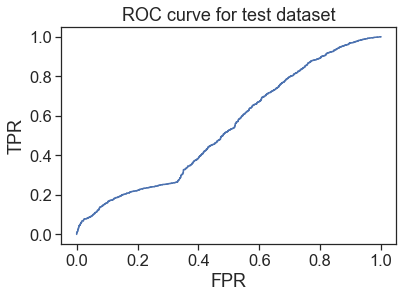

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, th = roc_curve(y_true=y_true['test'], y_score=preds_prob['test'])
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title(f'ROC curve for test dataset')

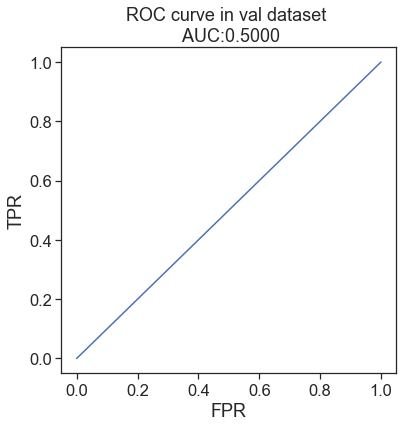

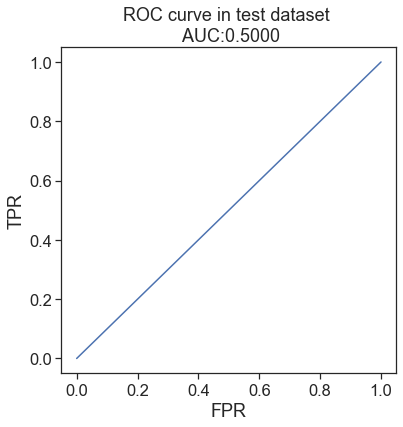

In [ ]:
for k, v in y_true.items():
    fpr, tpr, _ = roc_curve(v, preds[k])
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots(figsize=(6,6))
    plt.plot(fpr, tpr)
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.title(f'ROC curve in {k} dataset \n AUC:{roc_auc:.4f}')